## 特征组合
学习目标：
- 添加其他的合成特征来改进之前模型
- 使用输入函数把Pandas DataFrame对象转换为Tensors，使用fit()和predict()函数
- 使用FTRL优化算法对模型进行训练
- 通过独热编码、分箱和特征组合创建新的合成特征

### 设置
加载加州住房数据集。

In [22]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_df = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv",
                                   sep=',')
california_housing_df = california_housing_df.reindex(np.random.permutation(california_housing_df.index))

In [23]:
# 预处理特征
def preprocess_features(california_housing_df):
    """预处理房价的DataFrame，准备输入特征,添加人为特征
    Args:
        california_housing_df: 包含加州房价数据的df
    Returns:
        包含处理后特征的DataFrame
    """
    selected_features = california_housing_df[["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    # 创建额外的特征
    processed_features["rooms_per_person"] = (california_housing_df["total_rooms"] / california_housing_df["population"])
    return processed_features

# 预处理目标
def preprocess_targets(california_housing_df):
    """从加州房价DataFrame准备目标特征，即标签
    Args:
        california_housing_dataframe: 包含加州房价数据的df
    Returns:
        包含目标标签的df
    """
    output_targets = pd.DataFrame()
    # 将目标标签的值缩放
    output_targets["median_house_value"] = (california_housing_df["median_house_value"] / 1000.0)
    return output_targets


In [24]:

# 选择前12000/17000用于训练
training_examples = preprocess_features(california_housing_df.head(12000))
training_targets = preprocess_targets(california_housing_df.head(12000))

# 选择最后的5000用于验证
validation_examples = preprocess_features(california_housing_df.tail(5000))
validation_targets = preprocess_targets(california_housing_df.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2628.5,536.8,1419.5,499.2,3.9,2.0
std,2.1,2.0,12.6,2100.3,409.3,1091.8,374.6,1.9,1.0
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.0,297.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2123.0,433.0,1165.5,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3155.2,651.0,1727.0,607.0,4.8,2.3
max,42.0,-114.5,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2680.1,545.6,1453.7,506.2,3.9,2.0
std,2.1,2.0,12.5,2360.1,449.5,1272.1,407.4,1.9,1.4
min,32.5,-124.3,1.0,11.0,3.0,8.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.0,296.0,786.8,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2142.5,435.5,1170.0,411.0,3.6,1.9
75%,37.7,-118.0,37.0,3141.2,643.0,1701.0,601.0,4.7,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,208.0
std,115.9
min,15.0
25%,120.1
50%,181.3
75%,265.7
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.6
std,116.3
min,15.0
25%,118.7
50%,177.4
75%,262.9
max,500.0


In [25]:
def my_input_fn(features, targets, batch_size=1,shuffle=True, num_epochs=None):
    """使用多个特征训练一个线性回归器
    Args:
        features: 特征的DataFrame
        targets: 目标的DataFrame
        batch_size: 传递给模型的批大小
        shuffle: 是否打乱数据
        num_epochs: 数据重复的epochs数
    Returns:
        下一批数据元组(features, labels)
    """
    # 转换DataFrame到numpy数组
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # 构建数据集
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # 打乱数据
    if shuffle:
        ds = ds.shuffle(10000)
        
    # 返回下一批数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [26]:
def construct_feature_columns(input_features):
    """构建特征列
    Args:
        input_features: 数值特征的名字
    Returns:
        特征列集
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

### FTRL优化算法
高维度的线性模型可以受益于一种基于梯度的优化方法，叫做FTRL。该算法的优势在于针对不同的系数以不同方式调整学习速率，该算法适用于很少采用非零值的特征(也非常适合支持L1正则化)

In [27]:
def train_model(learning_rate, 
                steps, 
                batch_size,
                feature_columns,
                training_examples, 
                training_targets, 
                validation_examples, 
                validation_targets):
    """使用多个特征训练一个线性回归模型
    """
    periods = 10
    steps_per_period = steps / periods
    
    # 定义优化器
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    # 创建一个线性回归器
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, 
                                                    optimizer=my_optimizer)
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)
    
    # 训练模型，并在每个周期输出loss
    print("Start training...")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # 计算预测
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
        
        # 计算训练和验证的损失
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # 输出结果
        print("period %02d : %.2f" % (period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished!")
    
    # 损失随周期变化图
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error via Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validaiton")
    plt.legend()
    
    return linear_regressor

Start training...
RMSE (on training data): 
period 00 : 274.21
period 01 : 245.28
period 02 : 204.62
period 03 : 195.28
period 04 : 186.36
period 05 : 132.39
period 06 : 253.12
period 07 : 217.75
period 08 : 190.25
period 09 : 109.46
Model training finished!


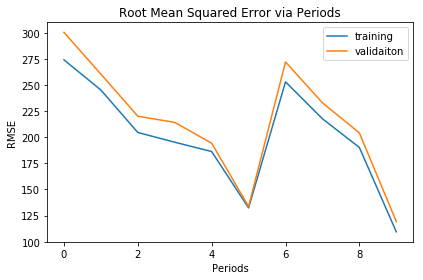

In [28]:
_ = train_model(learning_rate=1.0, 
                steps=500, 
                batch_size=5,
                feature_columns=construct_feature_columns(training_examples),
                training_examples=training_examples, 
                training_targets=training_targets,
               validation_examples=validation_examples,
               validation_targets=validation_targets)

### 离散特征的独热编码
通常来说，在训练逻辑回归模型之前，离散(字符串、枚举、整数)特征会转换为二元(0 or 1)特征系列。
例如，我们创建了一个合成特征，它的取值可能是{0, 1, 2}中的任意一个，如下：

|#|feature_value|
|---|---|
|0|2|
|1|0|
|2|1|

对于每种可能的取值都转换为一个新的二元实值特征，以上面表格为例，则有三个特征：

|#|feature_value_0|feature_value_1|feature_value_2|
|---|---|---|---|
|0|0.0|0.0|1.0|
|1|1.0|0.0|0.0|
|2|0.0|1.0|0.0|

### 分桶(分箱)特征
例如，我们可以把加州房价数据集中的人口信息(population)分为以下3个桶：
- bucket_0(< 5000): 对应人口分布较少的区域
- bucket_1(5000 - 25000): 对应人口分布适中的区域
- bucket_2(> 25000): 对应人口分布较多的区域

假如我们有以下数据：

```[[10001], [42000], [2500], [18000]]```

经过分桶操作后：

```[[1], [2], [0], [1]]```

现在的特征值是分桶索引，一般情况下，这些特征会被进一步表示成上述的独热表示法。

在TensorFlow中我们可以使用bucketized_column来定义分桶特征列。

In [29]:
# 根据分位数计算边界，使每个分桶包含相同数量的元素
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

# 把households特征分为7个buckets
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(households, 
                        boundaries=get_quantile_based_boundaries(california_housing_df["households"], 7))

# 把longitude特征分为10个buckets
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(longitude,
                        boundaries=get_quantile_based_boundaries(california_housing_df["longitude"], 10))

### 任务1. 使用分桶特征训练模型
我们已经对households和longitude进行了转换。我们使用分位数技巧，通过这种方式选择分桶边界，每个分桶的样本数量相同。

In [30]:
def construct_bucketized_feature_columns():
    """构建TensorFlow特征列
    Returns:
        特征列集合
    """
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf. feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
        training_examples["households"], 7))
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
        training_examples["longitude"], 10))
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
        training_examples["latitude"], 10))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
        training_examples["housing_median_age"], 5))
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
        training_examples["median_income"], 5))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
        training_examples["rooms_per_person"], 5))

    feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
    
    return feature_columns

Start training...
RMSE (on training data): 
period 00 : 169.39
period 01 : 142.99
period 02 : 126.50
period 03 : 115.34
period 04 : 107.45
period 05 : 101.65
period 06 : 97.14
period 07 : 93.74
period 08 : 90.90
period 09 : 88.53
Model training finished!


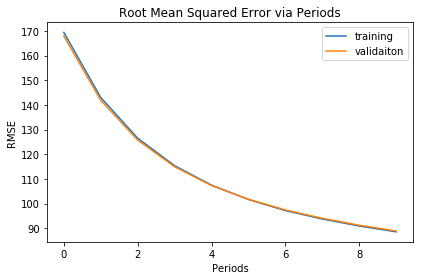

In [31]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_bucketized_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 任务2. 使用特征组合训练模型
在模型中添加longitude和latitude的特征组合。

In [32]:
def construct_crossed_feature_columns():
    """创建分桶和特征组合的特征列
    Returns:
        分桶和特征组合后的特征列集合
    """
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf. feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
        training_examples["households"], 7))
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
        training_examples["longitude"], 10))
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
        training_examples["latitude"], 10))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
        training_examples["housing_median_age"], 5))
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
        training_examples["median_income"], 5))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
        training_examples["rooms_per_person"], 5))
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

    feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
    
    return feature_columns

Start training...
RMSE (on training data): 
period 00 : 163.41
period 01 : 135.07
period 02 : 117.89
period 03 : 106.47
period 04 : 98.58
period 05 : 92.82
period 06 : 88.42
period 07 : 84.84
period 08 : 82.16
period 09 : 79.87
Model training finished!


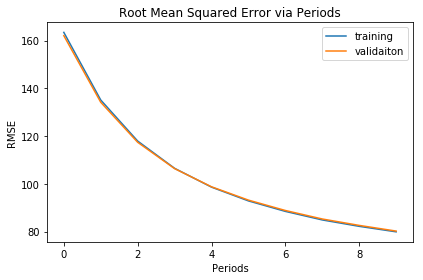

In [33]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_crossed_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)